Homework 4: Stereo 3D Reconstruction

In this homework, we take two images for a stereophoto in order to do 3D reconstruction. 

In [ ]:
# Project imports

import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D  

# K from last HW:

K = np.array([
    [1.50518378e+04,   0.0, 2.02730379e+03],
    [  0.0 ,1.48409101e+04, 1.47855129e+03],
    [  0.0 ,   0.0,   1.0]
], dtype=float)


Left: (4080, 3072, 3) Right: (4080, 3072, 3)


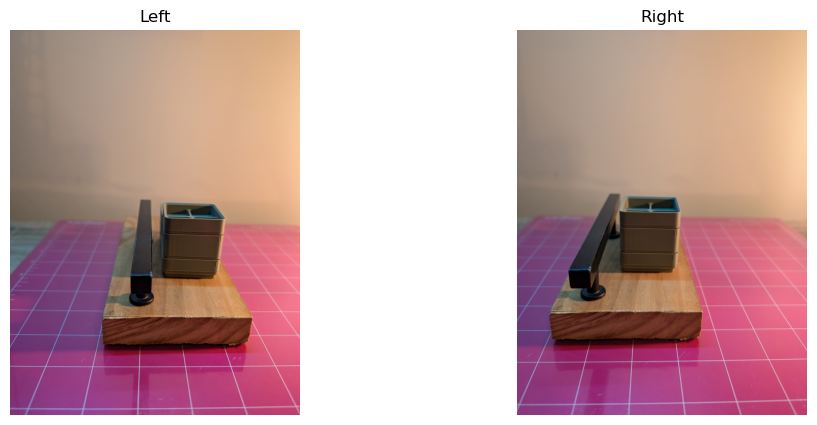

In [30]:
# Section 1: File setup

# load in images
left_img_path  = "/Users/ainee_f/Documents/School - Docs/computer_vision/homework04/images/old/PXL_20251029_011833481.jpg"  
right_img_path = "/Users/ainee_f/Documents/School - Docs/computer_vision/homework04/images/old/PXL_20251029_011836040.jpg" 

# load in K matrix from calibration homework (OpenCV's version)
# I used the same camera (Google Pixel 10 Pro)

# optional parameters:
sgbm_num_disparities = 128   # multiple of 16
sgbm_block_size      = 7     # odd

# display images (for homework presentation)

def show_side_by_side(imgL, imgR, titleL="Left", titleR="Right"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(imgL[..., ::-1]); plt.title(titleL); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(imgR[..., ::-1]); plt.title(titleR); plt.axis("off")
    plt.show()

imgL = cv2.imread(left_img_path, cv2.IMREAD_COLOR)
imgR = cv2.imread(right_img_path, cv2.IMREAD_COLOR)
assert imgL is not None and imgR is not None, "Could not load images. Check your paths."
print("Left:", imgL.shape, "Right:", imgR.shape)
show_side_by_side(imgL, imgR)

SIFT: Raw L=3421, R=2381, Good=643


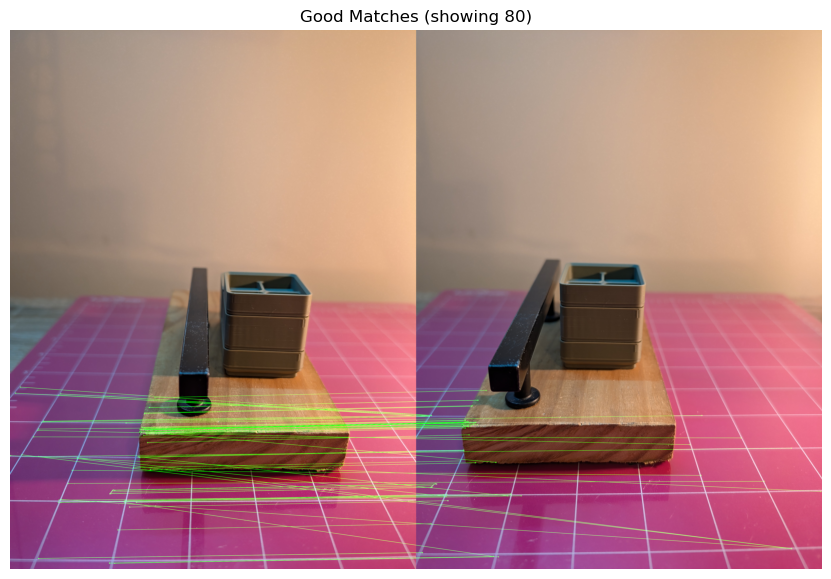

In [32]:
# Section 2: Feature matching
# We detect features with SIFT, match with FLANN, and filter using Lowe's ratio test.
# For visualization, we draw thicker & brighter match lines/points to improve visibility.

def detect_and_match(imgL, imgR, ratio=0.75, max_features=5000):
    # Convert to gray
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    # Detect + describe using SIFT
    sift = cv2.SIFT_create(nfeatures=max_features)
    k1, d1 = sift.detectAndCompute(grayL, None)
    k2, d2 = sift.detectAndCompute(grayR, None)

    # FLANN parameters for SIFT (float descriptors)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    knn_matches = flann.knnMatch(d1, d2, k=2)

    # Lowe’s ratio test
    good_matches = [m for m,n in knn_matches if m.distance < ratio * n.distance]

    print(f"SIFT: Raw L={len(k1)}, R={len(k2)}, Good={len(good_matches)}")
    return k1, k2, good_matches


def show_feature_matches_bold(imgL, kp1, imgR, kp2, matches, max_display=80):
    # subset to avoid clutter
    matches_to_show = matches[:max_display]

    # Draw default match image
    vis = cv2.drawMatches(
        imgL, kp1,
        imgR, kp2,
        matches_to_show, None,
        matchColor=(0,255,0),  # bright green matches
        singlePointColor=(0,0,255),  # bright red keypoints
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Enhance visibility post-drawing
    # Thickness and brightness boost using dilation
    kernel = np.ones((3,3), np.uint8)
    vis = cv2.dilate(vis, kernel, iterations=1)

    plt.figure(figsize=(14,7))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"Good Matches (showing {len(matches_to_show)})")
    plt.axis("off")
    plt.show()



# Run matching + visualization
kps1, kps2, good_matches = detect_and_match(imgL, imgR)
show_feature_matches_bold(imgL, kps1, imgR, kps2, good_matches)

# Extract matched pixel coordinates
pts1 = np.float32([kps1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kps2[m.trainIdx].pt for m in good_matches])

In [33]:
# Section 3: In this section of the code we use RANSAC filterting to retain only points that exist on the epipolar line associated
# with each point. Bad matches (large error) are discarded. (x’^T F x = 0)

# We also enforce rank-2 constraint because the Fundamental Matrix needs to be Rank = 2

# Lastly, eight point normalization is done because

def normalize_points(xy):
    '''
    Function for rnormalizing points
    '''
    mean = np.mean(xy, axis=0)
    d = xy - mean
    mean_dist = np.mean(np.sqrt(np.sum(d**2, axis=1))) + 1e-12
    s = np.sqrt(2.0) / mean_dist
    T = np.array([[s, 0, -s*mean[0]],
                  [0, s, -s*mean[1]],
                  [0, 0, 1]], dtype=float)
    xy_h = np.hstack([xy, np.ones((xy.shape[0],1))])
    xy_n = (T @ xy_h.T).T[:, :2]
    return xy_n, T

def eight_point_F(xy1, xy2):
    '''
    Function for F denormalization
    '''
    x1n, T1 = normalize_points(xy1)
    x2n, T2 = normalize_points(xy2)
    x1 = np.hstack([x1n, np.ones((x1n.shape[0],1))])
    x2 = np.hstack([x2n, np.ones((x2n.shape[0],1))])
    A = np.stack([
        x2[:,0]*x1[:,0], x2[:,0]*x1[:,1], x2[:,0],
        x2[:,1]*x1[:,0], x2[:,1]*x1[:,1], x2[:,1],
        x1[:,0],         x1[:,1],         np.ones(x1.shape[0])
    ], axis=1)
    _, _, VT = np.linalg.svd(A)
    f = VT[-1]
    F = f.reshape(3,3)
    U, S, VT = np.linalg.svd(F)
    S[-1] = 0.0
    F_rank2 = U @ np.diag(S) @ VT
    F_denorm = T2.T @ F_rank2 @ T1
    return F_denorm / (F_denorm[2,2] + 1e-12)

F_ransac, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1.0, confidence=0.999)
inliers1 = pts1[mask.ravel()==1]
inliers2 = pts2[mask.ravel()==1]
print("RANSAC inliers:", inliers1.shape[0], "/", pts1.shape[0])

F = eight_point_F(inliers1, inliers2)
print("F =\n", F)


RANSAC inliers: 410 / 643
F =
 [[-9.05616759e-10  1.16421915e-07 -2.56318891e-04]
 [-1.93365066e-07  2.66661551e-08  1.81337753e-02]
 [ 5.57114583e-04 -1.82231096e-02  1.00000000e+00]]


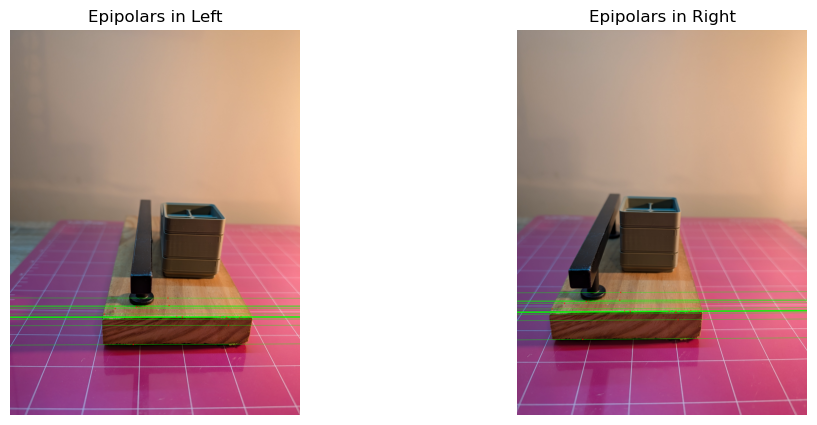

In [34]:
# Section 4: In this section, we draw the epipolars found from the previous section for visualization

def draw_epipolars(F, imgL, imgR, pts1, pts2, num=16):
    h1, w1 = imgL.shape[:2]
    h2, w2 = imgR.shape[:2]

    n = min(num, len(pts1))
    idx = np.random.choice(len(pts1), size=n, replace=False)
    p1 = pts1[idx]; p2 = pts2[idx]

    p1_h = np.hstack([p1, np.ones((n,1))])
    p2_h = np.hstack([p2, np.ones((n,1))])

    linesR = (F @ p1_h.T).T
    linesL = (F.T @ p2_h.T).T

    L = imgL.copy()
    R = imgR.copy()

    line_color = (0,255,0)   # bright green
    pt_color   = (0,0,255)   # red circles for points

    thickness = 2
    radius = 6

    for (a,b,c), pt in zip(linesR, p2):
        if abs(b) > 1e-9:
            x0,y0 = 0, int(-c/b)
            x1,y1 = w2-1, int(-(c + a*(w2-1))/b)
        else:  # vertical line case
            x0 = x1 = int(-c/a)
            y0,y1 = 0, h2-1
        
        cv2.line(R, (x0,y0), (x1,y1), line_color, thickness, cv2.LINE_AA)
        cv2.circle(R, tuple(np.int32(pt)), radius, pt_color, -1)

    for (a,b,c), pt in zip(linesL, p1):
        if abs(b) > 1e-9:
            x0,y0 = 0, int(-c/b)
            x1,y1 = w1-1, int(-(c + a*(w1-1))/b)
        else:
            x0 = x1 = int(-c/a)
            y0,y1 = 0, h1-1
        
        cv2.line(L, (x0,y0), (x1,y1), line_color, thickness, cv2.LINE_AA)
        cv2.circle(L, tuple(np.int32(pt)), radius, pt_color, -1)

    show_side_by_side(L, R, "Epipolars in Left", "Epipolars in Right")

draw_epipolars(F, imgL, imgR, inliers1, inliers2, num=16)


In [35]:
# Section 5: Deriving E from F: here we find the Essential matrix, the pose (based on extrinsics R and t), and triangulate


E = K.T @ F @ K
U, S, VT = np.linalg.svd(E)
Smean = 0.5*(S[0]+S[1])
E = U @ np.diag([Smean, Smean, 0.0]) @ VT
print("E =\n", E)

retval, R, t, mask_pose = cv2.recoverPose(E, inliers1, inliers2, K)
print("Recovered pose inliers:", int(retval))
print("R =\n", R)
print("t (unit) =\n", t.ravel())

P1 = K @ np.hstack([np.eye(3), np.zeros((3,1))])
P2 = K @ np.hstack([R, t])

points4D = cv2.triangulatePoints(P1, P2, inliers1.T, inliers2.T)
points3D = (points4D[:3] / (points4D[3] + 1e-12)).T

def depth_positive(P, X):
    X_h = np.hstack([X, np.ones((X.shape[0],1))]).T
    Z = (P @ X_h)[2]
    return Z > 0

mask_ok = np.logical_and(depth_positive(P1, points3D), depth_positive(P2, points3D))
points3D = points3D[mask_ok]
print("3D points kept:", points3D.shape[0])


E =
 [[-1.64886944e-01  2.60054410e+01 -1.54129189e+00]
 [-4.31751343e+01  3.31116777e+00  2.64022056e+02]
 [ 3.64155308e+00 -2.66231013e+02  3.81824113e+00]]
Recovered pose inliers: 410
R =
 [[ 0.9978673   0.01014864  0.06448138]
 [-0.00926074  0.99985835 -0.01405387]
 [-0.06461487  0.01342676  0.99781994]]
t (unit) =
 [-0.99524823 -0.00440329 -0.0972706 ]
3D points kept: 410


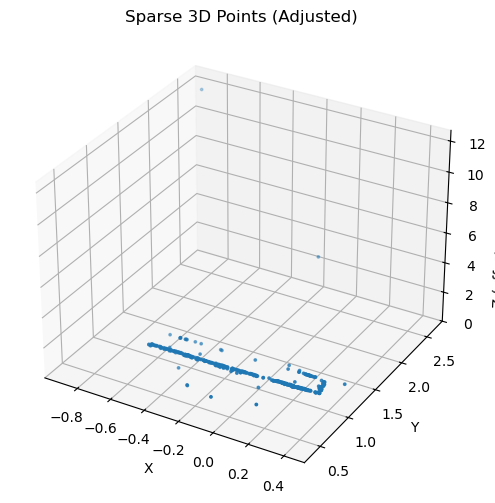

Saved: triangulated_points_adjusted.ply


In [ ]:
# Section 6: Lastly, we visualize the points with a 3D plot and export them


# Make Z start at zero (positive depth)
Zmin = np.min(points3D[:,2])
points3D_adj = points3D.copy()
points3D_adj[:,2] -= Zmin

X = points3D_adj[:,0]
Y = points3D_adj[:,1]
Z = points3D_adj[:,2]

fig = plt.figure(figsize=(16,5))

# 3D View
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax1.scatter(X, Y, Z, s=3)
ax1.set_title("3D View")
ax1.set_xlabel("X"); ax1.set_ylabel("Y"); ax1.set_zlabel("Z (depth)")

# Top-down projection (X-Y)
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(X, Y, s=3)
ax2.set_aspect('equal', adjustable='box')
ax2.set_title("Top View (XY)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")

# Depth profile (Y-Z)
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(Z, Y, s=3)
ax3.set_aspect('equal', adjustable='box')
ax3.set_title("Front View (YZ)")
ax3.set_xlabel("Z (depth)"); ax3.set_ylabel("Y")

plt.tight_layout()
plt.show()



def save_ply(filename, verts, rgb=None):
    verts = np.asarray(verts)
    if rgb is None:
        rgb = np.zeros_like(verts, dtype=np.uint8)
    header = "ply\nformat ascii 1.0\n" + f"element vertex {len(verts)}\n"
    header += "property float x\nproperty float y\nproperty float z\n"
    header += "property uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n"
    with open(filename, "w") as f:
        f.write(header)
        for (x,y,z), (r,g,b) in zip(verts, rgb):
            f.write(f"{x} {y} {z} {int(r)} {int(g)} {int(b)}\n")\
            


ply_path = "triangulated_points_adjusted.ply"
save_ply(ply_path, points3D_adj)
print("Saved:", ply_path)